In [1]:
import sqlite3 as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.interpolate import interp1d
import plotly.io as pio

In [2]:
def db_to_df(database_name: str = "plitech_database.db") -> pd.DataFrame:
    with sq.connect(database=database_name) as conn:
        try :
            df = pd.read_sql_query('select * from recap',conn)
        except Exception as e:
            print("Error",e)
    return df

def preprocessing(df:pd.DataFrame) -> pd.DataFrame:
    return df.assign(date_arrivé = pd.to_datetime(df["date_arrivé"]),
              qty_tole = df.qty*df.longueur*df.largeur/2_000_000,
              ca = df.total_frais_pliage + df.total_vente_tole,
              epaisseur = pd.Categorical(df.epaisseur,ordered=True,
                                         categories=['30/100', '40/100','50/100','60/100',
                                                     '7/10', '8/10', '9/10','10/10','11/10',
                                                     '12/10', '15/10', '2mm'])
              ).drop('epaisseur_order',axis=1)
    
    
    
    

In [3]:

df = preprocessing(db_to_df('plitech_database.db'))
df
#df_tpn = df.loc[:,:'epaisseur']
df_facture = df.loc[:,'nom_client':].drop(['is_item_sold','qty_tole'],axis=1).drop_duplicates().assign(
    MY = df.date_arrivé.dt.strftime('%b %Y')
)


In [4]:
fig = px.histogram(df.sort_values('epaisseur'),x='epaisseur',y='qty_tole')
fig.update_layout(xaxis_title='Epaisseur',yaxis_title="Quantité",title="Quantité tôle par épaisseur")
pio.write_image(fig,'repartition par epaisseur.jpg')
fig.show()

In [5]:
fig = px.histogram(df,x='date_arrivé',y='qty_tole')
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y")
fig.update_layout(bargap=0.3)
fig.update_layout(xaxis_title="Date",yaxis_title="Quantité Tôle" ,title = "Tôle par mois")
pio.write_image(fig,"Tôle par mois.jpg")
fig.show()

In [6]:
fig = px.histogram(df_facture,x='date_arrivé',y='ca')
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y")
fig.update_layout(bargap=0.3)
fig.update_layout(xaxis_title="Date",yaxis_title="Chiffre d'affaire" ,title = "Chiffre d'affaire par mois")
pio.write_image(fig,"Chiffre d'affaire par mois.jpg")
fig.show()

In [7]:
print(f"""Rapport du {df.date_arrivé.min().strftime('%d %B %Y')} - {df.date_arrivé.max().strftime('%d %B %Y')}
      Nbr. TPN: {df.qty_tole.sum():.2f}
      Nbr. TPN journalier en moyenne: {df.qty_tole.sum()/(26*6):.2f}
      Nbr. Client: {df.nom_client.nunique()}
      ca : {df_facture.ca.sum():,.0f}
      
      
      
      
      
      """)

Rapport du 01 March 2023 - 31 August 2023
      Nbr. TPN: 430.99
      Nbr. TPN journalier en moyenne: 2.76
      Nbr. Client: 64
      ca : 12,277,800
      
      
      
      
      
      


In [8]:
df1 = df.groupby(["nom_client","date_arrivé","heure_arrivé"]).agg({'ca':'mean','num_facture':'mean','qty_tole':sum,"total_vente_tole":'mean',	"total_frais_pliage":'mean',	"total_remise":'mean',	"total_chute":'mean'}).reset_index()
df2 = df.groupby(["num_facture","date_arrivé","nom_client"]).agg({'ca':'mean','qty_tole':sum,"total_vente_tole":'mean',	"total_frais_pliage":'mean',	"total_remise":'mean',	"total_chute":'mean'}).reset_index()
df1['frais_pliage_by_tole'] = df.total_frais_pliage/df.qty_tole



df2 = df2.set_index("date_arrivé")

In [9]:
df

,qty,is_plain,longueur,largeur,type,epaisseur,nom_client,date_arrivé,heure_arrivé,total_vente_tole,total_frais_pliage,total_remise,total_chute,num_facture,qty_tole,is_item_sold,ca
0,6,Oui,2500,1250,TPP,30/100,TIANA,2023-06-08,11:30:00,0,54000,0,0.00,89,9.3750,Non,54000
1,5,Oui,2500,1250,TPP,30/100,TIANA,2023-06-12,16:00:00,0,45000,0,0.00,95,7.8125,Non,45000
2,1,Oui,2000,200,TPP,30/100,FINARITRA,2023-05-17,08:17:00,0,9000,0,0.00,67,0.2000,Non,9000
3,1,Non,2000,1000,TPP,30/100,TINA,2023-03-10,00:00:00,0,27000,0,0.00,8,1.0000,Non,27000
4,2,Oui,2500,40,TPP,30/100,ROBINSON,2023-06-13,11:45:00,0,14400,0,0.00,100,0.1000,Non,14400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2,Non,2000,1000,TPN,8/10,RADO,2023-08-31,10:15:00,0,30000,0,0.00,246,2.0000,Non,30000
291,2,Non,2000,1000,TPN,10/10,HERY,2023-08-31,14:46:00,0,20100,0,0.31,247,2.0000,Non,20100
292,4,Non,2000,1000,TPN,12/10,HERY,2023-08-31,14:00:00,0,56000,0,0.21,248,4.0000,Non,56000
293,2,Non,2000,1000,TPN,8/10,LIVA,2023-08-31,15:30:00,0,24000,0,0.00,249,2.0000,Non,24000


In [10]:
[(i,i) for i in df.epaisseur.sort_values().unique().to_list()]

[('30/100', '30/100'),
 ('40/100', '40/100'),
 ('50/100', '50/100'),
 ('60/100', '60/100'),
 ('7/10', '7/10'),
 ('8/10', '8/10'),
 ('9/10', '9/10'),
 ('10/10', '10/10'),
 ('11/10', '11/10'),
 ('12/10', '12/10'),
 ('15/10', '15/10'),
 ('2mm', '2mm')]

In [54]:
df1.num_facture.sort_values()

143      1.0
139      2.0
191      3.0
54       4.0
199      5.0
       ...  
122    225.0
104    226.0
186    227.0
190    228.0
9      229.0
Name: num_facture, Length: 219, dtype: float64

In [53]:
df2.num_facture.nunique()

221

In [245]:
df2 = df2.loc['03-2023':'07-2023']

In [246]:

df_monthly = df2.resample('M').sum()
df_monthly['MY'] = df_monthly.index.strftime("%b - %Y")

C:\Users\USER\AppData\Local\Temp\ipykernel_24428\1842776995.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [247]:
df_monthly

,num_facture,ca,qty_tole,total_vente_tole,total_frais_pliage,total_remise,total_chute,MY
date_arrivé,,,,,,,,
2023-03-31,599,2671900.0,67.600000,1740000.0,931900.0,0.0,0.000000,mars - 2023
2023-04-30,878,429800.0,25.375100,104000.0,325800.0,0.0,0.000000,avr. - 2023
2023-05-31,1974,679500.0,26.431200,275500.0,404000.0,0.0,0.469000,mai - 2023
2023-06-30,5183,1165900.0,97.335077,97000.0,1068900.0,0.0,0.876000,juin - 2023
2023-07-31,9019,4316300.0,100.050912,3067600.0,1248700.0,104800.0,3.698396,juil. - 2023


In [261]:
fig = px.bar(df_monthly,x='MY',y='ca')
fig.update_layout(xaxis_title="Mois",yaxis_title="CA (MGA)",title="Période Mars-Juillet Chiffre d'affaire")

In [262]:
fig = px.bar(df_monthly,x='MY',y='total_frais_pliage')
fig.update_layout(xaxis_title="Mois",yaxis_title="Total_frais_pliage (MGA)",title="Période Mars-Juillet frais_pliage")

In [265]:
fig = px.bar(df_monthly,x='MY',y='qty_tole')
fig.update_layout(xaxis_title="Mois",yaxis_title="Quantité tôle",title="Période Mars-Juillet Quantité Tôle")

<AxesSubplot: xlabel='date_arrivé'>

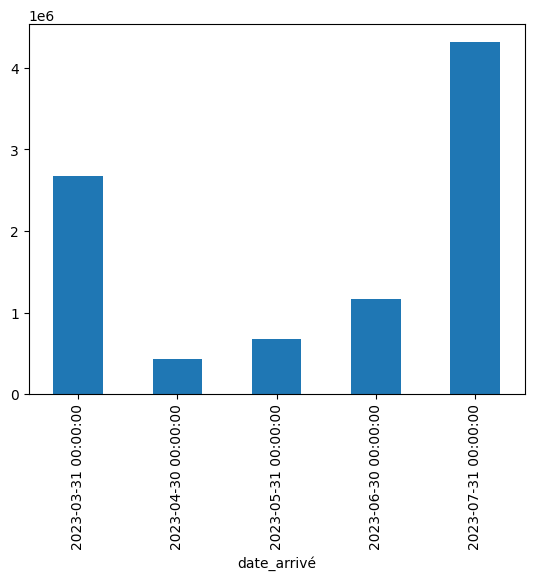

In [260]:
df2["ca"].resample('M').sum().plot(kind='bar')

<AxesSubplot: xlabel='date_arrivé'>

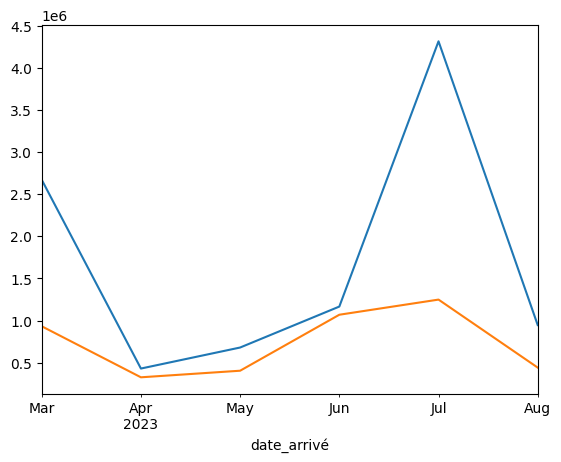

In [ ]:
df2['ca'].resample('M').sum().plot(kind="line")
df2['total_frais_pliage'].resample('M').sum().plot(kind="line")

In [ ]:
df2.nom_client.unique()

array(['RAHERY', 'NIX', 'SAFIDY', 'JOHARY', 'TINA', 'FANILO', 'BOLIDA',
       'KEVIN', 'SYLVAIN', 'MENJA', 'MANAMPY', 'JOSOA', 'TSARAVIDY',
       'MBOLA', 'AVOTRA', 'HANITRA', 'ANDRY', 'MAMY DADDY', 'SAMIR',
       'HANJA', 'ZO', 'MODESTE', 'FENOSOA', 'JUSTIN', 'PAPA', 'PASCAL',
       'LOVA', 'ROLAND', 'NELSON', 'FINARITRA', 'LBUILDING', 'FRANCIS',
       'TSOA', 'TIANA', 'SANTATRA', 'LIVA', 'MAMY', 'ROBINSON', 'MISA',
       'ELYSE', 'CHELAH', 'BOSCO', 'TSIRY', 'RADO', 'JAMES', 'HAJA',
       'EDMOND', 'FABRINA', 'EDMON', 'TIAVINA', 'SERGE', 'EMANUEL',
       'LANDRY', 'ERICK', 'HERY', 'ERNEST', 'TOKY', 'DOMINIQUE'],
      dtype=object)

In [ ]:
df2

,num_facture,nom_client,ca,qty_tole,total_vente_tole,total_frais_pliage,total_remise,total_chute
date_arrivé,,,,,,,,
2023-03-01,1,RAHERY,103000.0,1.0,88000.0,15000.0,0.0,0.000
2023-03-02,2,NIX,135000.0,1.3,115500.0,19500.0,0.0,0.000
2023-03-03,3,SAFIDY,405000.0,3.8,336000.0,69000.0,0.0,0.000
2023-03-03,4,JOHARY,12000.0,1.0,0.0,12000.0,0.0,0.000
2023-03-08,5,TINA,121000.0,1.0,103000.0,18000.0,0.0,0.000
...,...,...,...,...,...,...,...,...
2023-08-10,206,TOKY,6000.0,1.0,0.0,6000.0,0.0,0.000
2023-08-11,207,FANILO,90500.0,1.0,77000.0,13500.0,3700.0,0.000
2023-08-11,208,DOMINIQUE,6000.0,0.4,0.0,6000.0,0.0,0.040


In [ ]:
df2['date_arrivé'].dt.to_period('M')

KeyError: 'date_arrivé'

In [ ]:
monthly_new_clients = []
seen_clients = set()
for month, group in df2.groupby(df2['date_arrivé'].dt.to_period("M")):
    # Count unique clients for the current month
    new_clients = len(set(group['nom_client']) - seen_clients)
    
    # Add the count to the result list
    monthly_new_clients.append({'Month': month, 'New Clients': new_clients})
    
    # Update the set of seen clients
    seen_clients.update(group['nom_client'])

# Step 5: Create a DataFrame from the result list
result_df = pd.DataFrame(monthly_new_clients)

# Print or save the result
print(result_df)


     Month  New Clients
0  2023-03           16
1  2023-04            9
2  2023-05            8
3  2023-06           10
4  2023-07            9
5  2023-08            6


In [ ]:
df1.total_frais_pliage.sort_values(ascending=False).mean()

22010.333333333336

<AxesSubplot: xlabel='Month'>

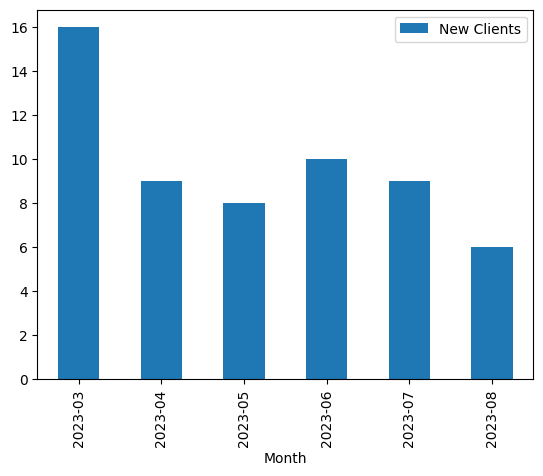

In [ ]:
result_df.set_index('Month').plot(kind='bar')

In [ ]:

df1.sort_values(by='total_frais_pliage',ascending=False).head()


,nom_client,date_arrivé,heure_arrivé,ca,num_facture,qty_tole,total_vente_tole,total_frais_pliage,total_remise,total_chute,frais_pliage_by_tole
43,HAJA,2023-07-07,15:37:00,214000.0,153.0,14.0,0.0,214000.0,0.0,0.463000,15000.0
112,MBOLA,2023-03-21,00:00:00,105000.0,23.0,7.0,0.0,105000.0,0.0,0.000000,15000.0
90,LIVA,2023-07-25,16:09:00,580000.0,184.0,7.0,490000.0,90000.0,26500.0,0.004356,12000.0
195,ZO,2023-06-20,14:58:00,83600.0,108.0,3.0,0.0,83600.0,0.0,0.153000,1600000.0
53,JOHARY,2023-03-31,00:00:00,77000.0,33.0,7.0,0.0,77000.0,0.0,0.000000,10000.0


In [ ]:
(df1.total_frais_pliage/df1.qty_tole).mean()
#df1.total_frais_pliage.sum()

18817.594429693698

In [ ]:
(df1.qty_tole-df1.total_chute).sum()

340.28315399999997

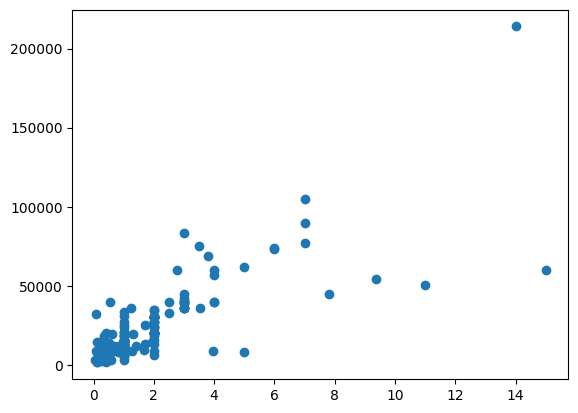

In [ ]:
plt.scatter(df1.qty_tole,df1.total_frais_pliage)

In [ ]:
df.columns

Index(['qty', 'is_plain', 'longueur', 'largeur', 'type', 'epaisseur',
       'nom_client', 'date_arrivé', 'heure_arrivé', 'total_vente_tole',
       'total_frais_pliage', 'total_remise', 'total_chute', 'num_facture',
       'qty_tole', 'epaisseur_order', 'is_item_sold', 'ca'],
      dtype='object')

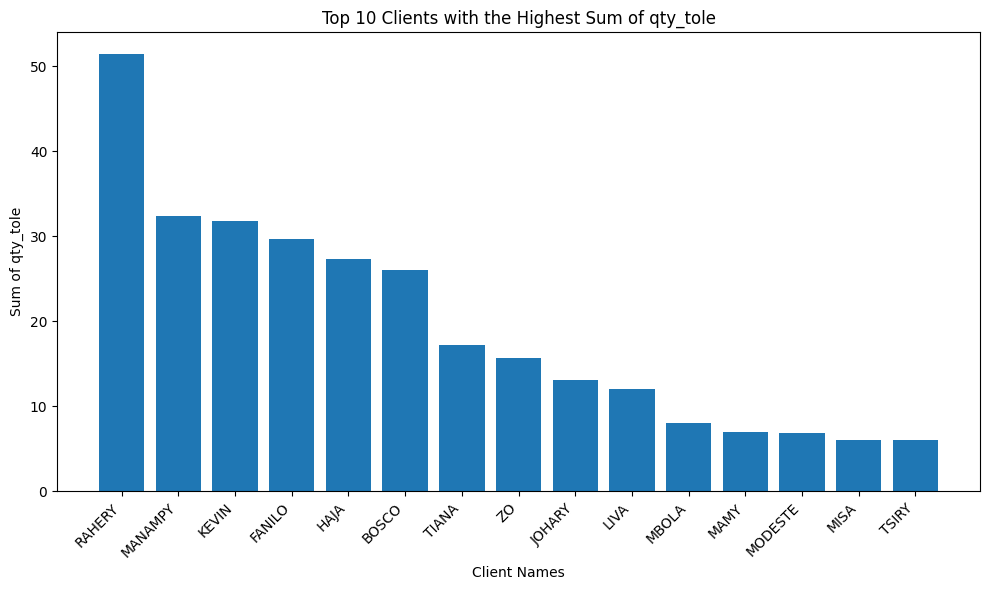

In [ ]:
grouped_data = df1.groupby('nom_client')['qty_tole'].sum()

# Sort the data in descending order and select the top 10 clients
top_10_clients = grouped_data.sort_values(ascending=False).head(15)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_10_clients.index, top_10_clients.values)
plt.xlabel('Client Names')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Clients with the Highest Sum of qty_tole')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

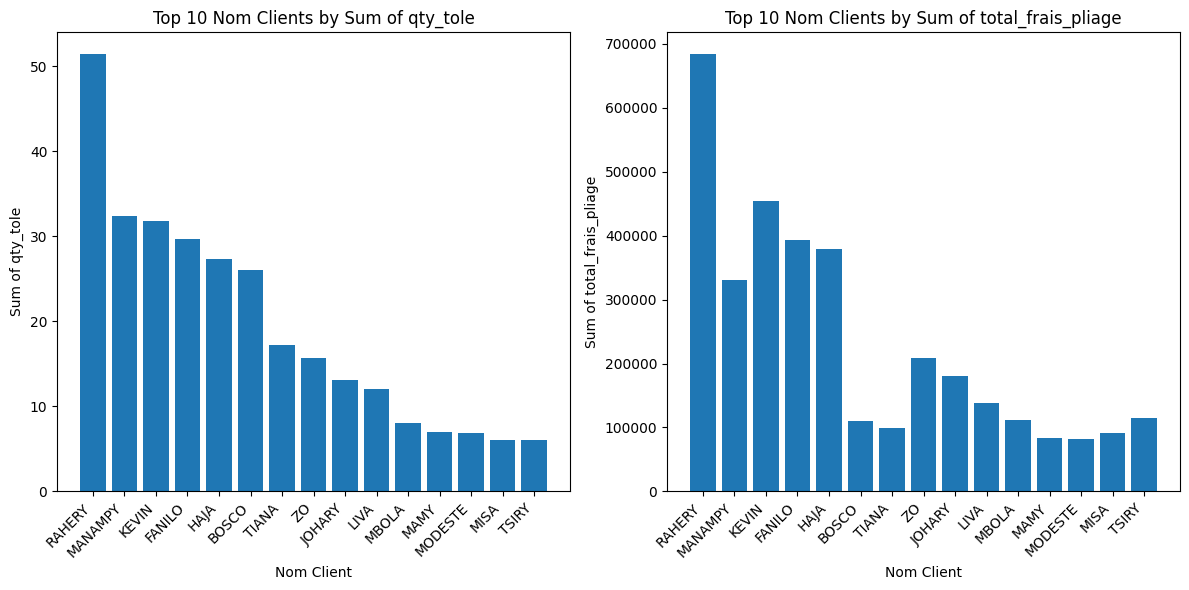

In [ ]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
sum_qty_tole = grouped_data['qty_tole'].sum()
sum_total_frais_pliage = grouped_data['total_frais_pliage'].sum()

# Step 3: Combine the sums into a new DataFrame
sum_df = pd.DataFrame({
    'sum_qty_tole': sum_qty_tole,
    'sum_total_frais_pliage': sum_total_frais_pliage
})

# Step 4: Sort the data based on the calculated sums in descending order
sum_df = sum_df.sort_values(by=['sum_qty_tole', 'sum_total_frais_pliage'], ascending=False)

# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = sum_df.head(15)

# Step 6: Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(top_10_clients.index, top_10_clients['sum_qty_tole'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nom Client')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Nom Clients by Sum of qty_tole')

plt.subplot(1, 2, 2)
plt.bar(top_10_clients.index, top_10_clients['sum_total_frais_pliage'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nom Client')
plt.ylabel('Sum of total_frais_pliage')
plt.title('Top 10 Nom Clients by Sum of total_frais_pliage')

plt.tight_layout()
plt.show()


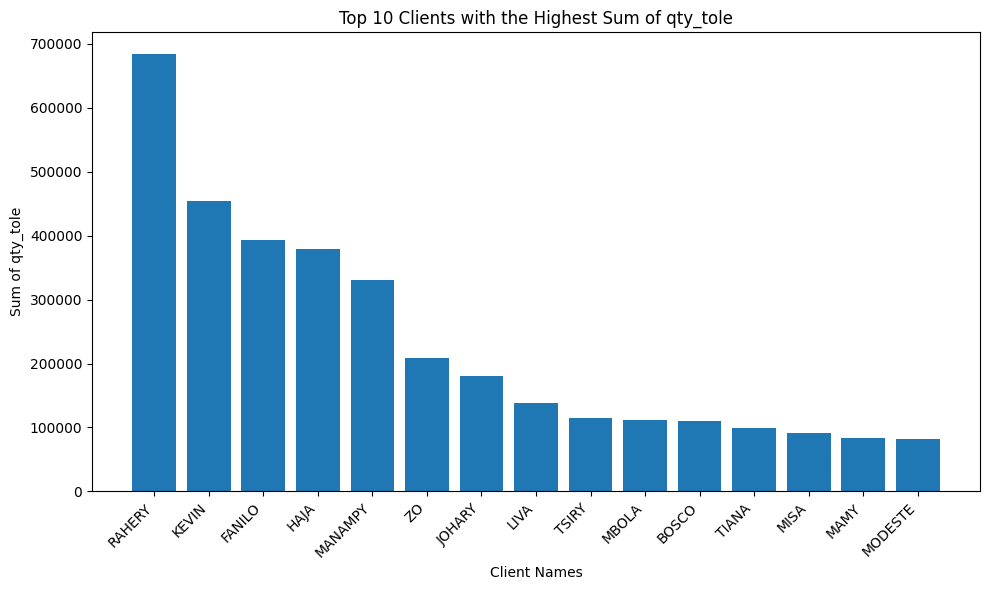

In [ ]:
grouped_data = df1.groupby('nom_client')['total_frais_pliage'].sum()

# Sort the data in descending order and select the top 10 clients
top_10_clients = grouped_data.sort_values(ascending=False).head(15)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_10_clients.index, top_10_clients.values)
plt.xlabel('Client Names')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Clients with the Highest Sum of qty_tole')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
sum_df = grouped_data['total_frais_pliage'].sum()


# Step 4: Sort the data based on the calculated sums in descending order
sum_df = sum_df.sort_values(ascending=False)
# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = sum_df.head(10).reset_index()

# Step 6: Plot the results using Plotly Express
fig = px.bar(top_10_clients, x='nom_client', y='total_frais_pliage',
             title='Top 10 Nom Clients by Sum of qty_tole and total_frais_pliage',
             labels={'value': 'Sum'})

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
sum_qty_tole = grouped_data['qty_tole'].sum()
sum_total_frais_pliage = grouped_data['total_frais_pliage'].sum()

# Step 3: Combine the sums into a new DataFrame
sum_df = pd.DataFrame({
    'sum_qty_tole': sum_qty_tole,
    'sum_total_frais_pliage': sum_total_frais_pliage
}).reset_index()

# Step 4: Sort the data based on the calculated sums in descending order
sum_df = sum_df.sort_values(by=['sum_qty_tole', 'sum_total_frais_pliage'], ascending=False)

# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = sum_df.head(10)

# Step 6: Plot the results using Plotly Express
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=top_10_clients['nom_client'], y=top_10_clients['sum_total_frais_pliage'],
                     name='Sum of total_frais_pliage'), secondary_y=False)
fig.add_trace(go.Bar(x=top_10_clients['nom_client'], y=top_10_clients['sum_qty_tole'],
                     name='Sum of qty_tole'), secondary_y=True)

fig.update_layout(title='Top 10 Nom Clients by Sum of qty_tole and total_frais_pliage',
                  xaxis_tickangle=-45, xaxis_title='Nom Client', barmode='group')

fig.update_yaxes(title_text='Sum of total_frais_pliage', secondary_y=False)
fig.update_yaxes(title_text='Sum of qty_tole', secondary_y=True)

fig.show()

In [ ]:
df1.nom_client.value_counts()

RAHERY        41
KEVIN         26
FANILO        23
MANAMPY       15
ZO            10
JOHARY         7
MODESTE        7
HAJA           5
LIVA           3
MISA           3
ERICK          2
ROLAND         2
MBOLA          2
BOLIDA         2
MAMY DADDY     2
MAMY           2
BOSCO          2
TSARAVIDY      2
TSIRY          2
TIANA          2
TINA           2
EDMOND         2
SAFIDY         1
SANTATRA       1
NELSON         1
SYLVAIN        1
SERGE          1
NIX            1
PAPA           1
PASCAL         1
TSOA           1
RADO           1
TIAVINA        1
TOKY           1
ROBINSON       1
SAMIR          1
ANDRY          1
MENJA          1
FINARITRA      1
CHELAH         1
DOMINIQUE      1
EDMON          1
ELYSE          1
EMANUEL        1
ERNEST         1
FABRINA        1
FENOSOA        1
FRANCIS        1
AVOTRA         1
HANITRA        1
HANJA          1
HERY           1
JAMES          1
JOSOA          1
JUSTIN         1
LANDRY         1
LBUILDING      1
LOVA           1
Name: nom_clie

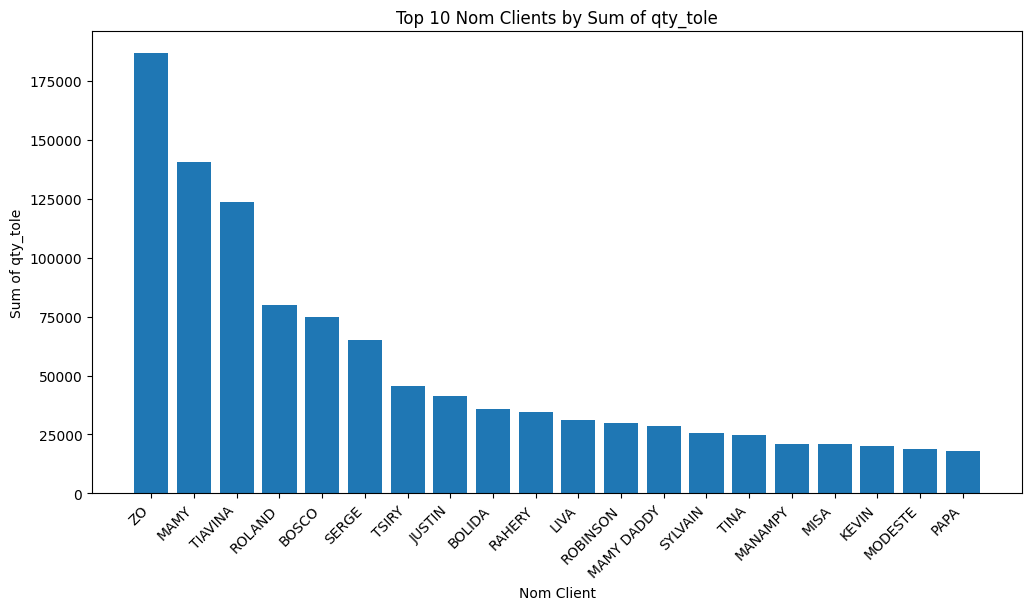

In [ ]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
mean_frais_pliage_by_tole = grouped_data['frais_pliage_by_tole'].mean()



# Step 4: Sort the data based on the calculated sums in descending order
mean_frais_pliage_by_tole = mean_frais_pliage_by_tole.sort_values(ascending=False)

# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = mean_frais_pliage_by_tole.head(20)

# Step 6: Plot the results
plt.figure(figsize=(12, 6))

plt.subplot()
plt.bar(top_10_clients.index, top_10_clients)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nom Client')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Nom Clients by Sum of qty_tole')


plt.show()

In [ ]:
top_10_clients.reset_index()

,nom_client,frais_pliage_by_tole
0,ZO,186677.073452
1,MAMY,140711.060084
2,TIAVINA,123750.000000
3,ROLAND,79798.705967
4,BOSCO,75000.000000
5,SERGE,65000.000000
6,TSIRY,45500.000000
7,JUSTIN,41481.481481
8,BOLIDA,36000.000000
9,RAHERY,34318.887237


In [ ]:
df.nom_client.nunique()

58

In [ ]:
df1.total_frais_pliage.sum()/df1.qty_tole.sum()

12569.323083294108

In [ ]:
df1.groupby('nom_client')["qty_tole"].sum().sort_values(ascending=False).index[0]

'RAHERY'

In [ ]:
def plot_by_month(result):
    result['date_arrivé'] = pd.to_datetime(result['date_arrivé'])

    # Step 2: Extract the month and year from 'date_arrivé'
    result['month_year'] = result['date_arrivé'].dt.to_period('M')

    # Step 3: Group the data by month and year, and calculate the sum of 'total_frais_pliage'
    grouped_data = result.groupby('month_year')['total_frais_pliage'].sum()

    # Create a Streamlit app
 

    # Plot the data using matplotlib and display it in Streamlit
    plt.figure(figsize=(10, 6))
    plt.bar(grouped_data.index, grouped_data.values)
    plt.xlabel('Month-Year')
    plt.ylabel('Total Frais Pliage')
    plt.title('Total Frais Pliage by Month-Year')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot using Streamlit
    plt.show()

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

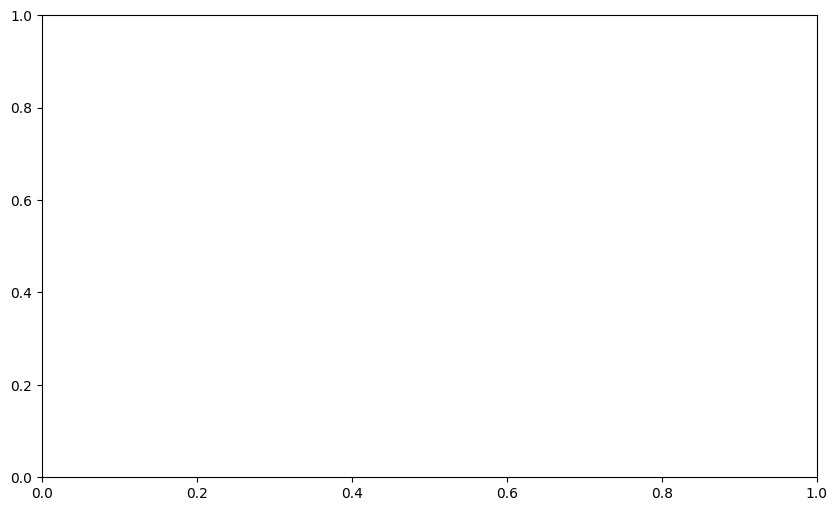

In [ ]:
plot_by_month(df1)

In [ ]:
result = df1
result['date_arrivé'] = pd.to_datetime(result['date_arrivé'])
result['month_year'] = result['date_arrivé'].dt.to_period('M')
grouped_data = result.groupby('month_year')['total_frais_pliage'].sum()


<BarContainer object of 2 artists>

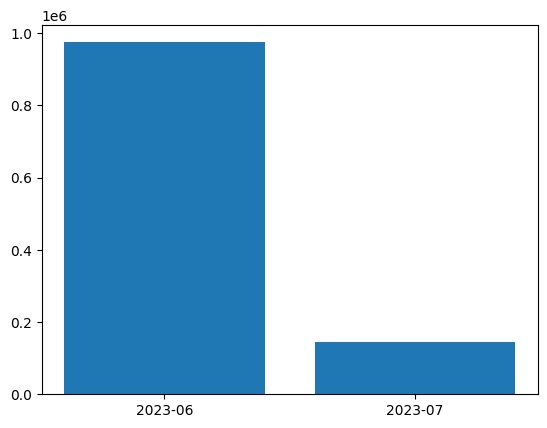

In [ ]:
plt.bar(grouped_data.index.astype(str),grouped_data.values)

In [ ]:
import pandas as pd
import streamlit as st
import plotly.express as px

# Assuming you have the dataset loaded into a DataFrame called 'df'
df = df1
# Step 1: Convert 'date_arrivé' to a proper date format
df['date_arrivé'] = pd.to_datetime(df['date_arrivé'])

# Step 2: Extract the month and year from 'date_arrivé'
df['month_year'] = df['date_arrivé'].dt.to_period('M')

# Step 3: Group the data by month and year, and calculate the sum of 'total_frais_pliage'
grouped_data = df.groupby('month_year')['total_frais_pliage'].sum().reset_index()




# Plot the data using Plotly Express and display it in Streamlit
fig = px.bar(grouped_data, x='month_year', y='total_frais_pliage',
             labels={'total_frais_pliage': 'Total Frais Pliage'},
             title='Total Frais Pliage by Month-Year')

fig.show()
fig.update_layout(xaxis_tickangle=-45)



TypeError: Object of type Period is not JSON serializable

,month_year,total_frais_pliage
0,2023-06,974300.0
1,2023-07,144200.0


<AxesSubplot: >

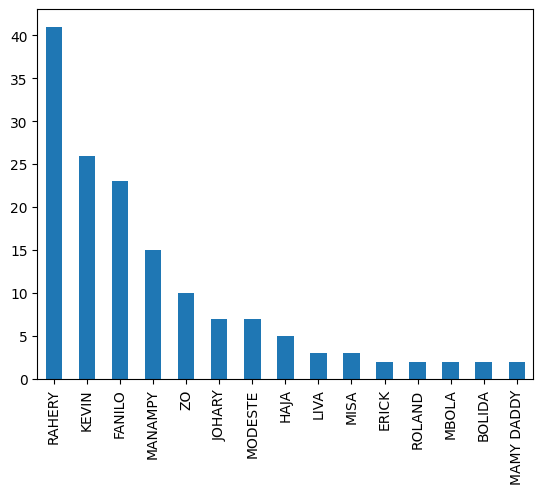

In [ ]:
df1.nom_client.value_counts().head(15).plot(kind='bar')

In [ ]:
fig = px.bar(df1.nom_client.value_counts().head(15))
fig.show()

In [ ]:
df1['date_arrivé'] = pd.to_datetime(df1['date_arrivé'], errors='coerce')

# Step 2: Sort the DataFrame by 'nom_client' and 'date_arrivé'
df_sorted = df1.sort_values(by=['nom_client', 'date_arrivé'])

# Step 3: Calculate the time difference between consecutive arrival dates for each client
df_sorted['arrival_interval'] = df_sorted.groupby('nom_client')['date_arrivé'].diff()

# Step 4: Calculate the average arrival interval in days
average_arrival_interval_days = df_sorted['arrival_interval'].mean().days

In [ ]:
average_arrival_interval_days



11

In [ ]:
df_sorted

,nom_client,date_arrivé,heure_arrivé,ca,num_facture,qty_tole,total_vente_tole,total_frais_pliage,total_remise,total_chute,frais_pliage_by_tole,month_year,arrival_interval
0,ANDRY,2023-04-03,00:00:00,6000.0,37.0,1.0000,0.0,6000.0,0.0,0.000000,5.760000e+03,2023-04,NaT
1,AVOTRA,2023-03-24,00:00:00,12000.0,26.0,1.0000,0.0,12000.0,0.0,0.000000,5.760000e+03,2023-03,NaT
2,BOLIDA,2023-03-09,00:00:00,8000.0,7.0,1.0000,0.0,8000.0,0.0,0.000000,4.500000e+04,2023-03,NaT
3,BOLIDA,2023-06-13,16:47:00,20000.0,96.0,0.4000,0.0,20000.0,0.0,0.032000,2.700000e+04,2023-06,96 days
4,BOSCO,2023-06-19,10:40:00,60000.0,106.0,15.0000,0.0,60000.0,0.0,0.000000,1.440000e+05,2023-06,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ZO,2023-06-20,14:58:00,83600.0,108.0,3.0000,0.0,83600.0,0.0,0.153000,1.600000e+06,2023-06,14 days
196,ZO,2023-06-22,10:30:00,10400.0,113.0,0.2500,0.0,10400.0,0.0,0.050000,1.000000e+04,2023-06,2 days
197,ZO,2023-07-03,15:58:00,8100.0,142.0,5.0000,0.0,8100.0,0.0,0.000000,5.333333e+04,2023-07,11 days
198,ZO,2023-07-18,09:31:00,7200.0,167.0,0.9362,0.0,7200.0,0.0,0.000000,6.864989e+04,2023-07,15 days


In [ ]:
df1

,nom_client,date_arrivé,heure_arrivé,ca,num_facture,qty_tole,total_vente_tole,total_frais_pliage,total_remise,total_chute,frais_pliage_by_tole,month_year
0,ANDRY,2023-04-03,00:00:00,6000.0,37.0,1.0000,0.0,6000.0,0.0,0.000000,5.760000e+03,2023-04
1,AVOTRA,2023-03-24,00:00:00,12000.0,26.0,1.0000,0.0,12000.0,0.0,0.000000,5.760000e+03,2023-03
2,BOLIDA,2023-03-09,00:00:00,8000.0,7.0,1.0000,0.0,8000.0,0.0,0.000000,4.500000e+04,2023-03
3,BOLIDA,2023-06-13,16:47:00,20000.0,96.0,0.4000,0.0,20000.0,0.0,0.032000,2.700000e+04,2023-06
4,BOSCO,2023-06-19,10:40:00,60000.0,106.0,15.0000,0.0,60000.0,0.0,0.000000,1.440000e+05,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
195,ZO,2023-06-20,14:58:00,83600.0,108.0,3.0000,0.0,83600.0,0.0,0.153000,1.600000e+06,2023-06
196,ZO,2023-06-22,10:30:00,10400.0,113.0,0.2500,0.0,10400.0,0.0,0.050000,1.000000e+04,2023-06
197,ZO,2023-07-03,15:58:00,8100.0,142.0,5.0000,0.0,8100.0,0.0,0.000000,5.333333e+04,2023-07
198,ZO,2023-07-18,09:31:00,7200.0,167.0,0.9362,0.0,7200.0,0.0,0.000000,6.864989e+04,2023-07


In [ ]:

import locale
ma_locale = locale.setlocale(locale.LC_ALL, '')
print(ma_locale)




French_France.1252


In [ ]:
x = 2099.236569633
print(f"{x:n}")

2 099,24


In [ ]:
df = pd.DataFrame()
df['client_name']=df2["nom_client"]
df['date']=df2.index
df['Month'] = df['date'].dt.to_period("M")
grouped = df.groupby(['Month', 'client_name'])

# Step 4: Count the number of times each client appears in a month
client_counts = grouped.size().reset_index(name='Client_Count')

# Step 5: Count the number of clients who returned at least 2 times in a month
returning_clients = client_counts[client_counts['Client_Count'] >= 2]

# Step 6: Calculate the ratio of returning clients to all distinct clients in each month
result = grouped['client_name'].nunique().reset_index(name='Distinct_Clients')
result['Returning_Clients'] = result['Month'].map(returning_clients.groupby('Month')['client_name'].count())
result['Return_Ratio'] = result['Returning_Clients'] / result['Distinct_Clients']
result['Month'] = result['Month'].dt.strftime('%Y-%m')
# Step 7: Plot the data using Plotly Express
fig = px.line(result, x='Month', y='Return_Ratio', title='Return Ratio of Clients Over Time')
fig.show()



In [ ]:
w = pd.concat([client_counts.groupby('Month').count(),returning_clients.groupby('Month').count()],axis=1)
w.columns = ['a','b','c','d']

In [ ]:
returning_clients.groupby('Month').count()

,client_name,Client_Count
Month,,
2023-03,7,7
2023-04,5,5
2023-05,7,7
2023-06,9,9
2023-07,8,8
2023-08,4,4


ValueError: Length mismatch: Expected axis has 5 elements, new values have 4 elements

In [ ]:
w['e'] = w['c']/w['a']*100
w = w.reset_index()


In [ ]:
w["Month"] = w["Month"].dt.strftime('%Y-%m')
px.line(w,x="Month",y='e')

In [ ]:
w

,a,b,c,d,e,Month
Month,,,,,,
2023-03,16,16,7,7,43.750000,NaN
2023-04,14,14,5,5,35.714286,NaN
2023-05,16,16,7,7,43.750000,NaN
2023-06,18,18,9,9,50.000000,NaN
2023-07,18,18,8,8,44.444444,NaN
2023-08,13,13,4,4,30.769231,NaN


In [ ]:
w = w.reset_index()

ValueError: cannot insert Month, already exists

In [72]:
import calendar

def jours_ouvrables_par_mois(annee, mois):
    # Obtenez le calendrier du mois
    cal = calendar.monthcalendar(annee, mois)

    # Initialisez un compteur pour les jours ouvrables
    jours_ouvrables = 0

    # Parcourez chaque semaine du calendrier
    for semaine in cal:
        for jour in semaine[:6]:
            # Vérifiez si le jour est dans les jours de semaine (1 à 5) et non égal à 0
            if jour !=0:
                jours_ouvrables += 1

    return jours_ouvrables

# Exemple d'utilisation
annee = 2023
mois = 11
resultat = jours_ouvrables_par_mois(annee, mois)
print(f"En {calendar.month_name[mois]} {annee}, il y a {resultat} jours ouvrables.")


En November 2023, il y a 26 jours ouvrables.


In [80]:
sum([jours_ouvrables_par_mois(2023,i) for i in range(1,13)])/12

26.0